In [1]:
!pip install keras-tuner --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install tensorflow==2.9.1

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import datetime

# Data manipulation libraries
import pandas as pd
import numpy as np
# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import Image

# Tensorflow libraries
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
import keras_tuner as kt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip list

Package                       Version
----------------------------- -----------
absl-py                       1.4.0
alabaster                     0.7.12
anyio                         3.5.0
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.11.7
asttokens                     2.0.5
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         22.1.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
black                         22.6.0
bleach                        4.1.0
brotlipy                      0.7.0
cachetools                    5.3.0
certifi                       2022.12.7
cffi                          1.15.1
chardet                       4.0.0
charset-normalizer            2.0.4
click  

In [ ]:
from platform import python_version
python_version()

'3.10.9'

In [ ]:
!pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\vinay\AppData\Local\Temp\pip-install-j1nfr_61\tensorflow-gpu_b922a2e4ad4b4b858b3ad90f27cf932f\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu did not

In [2]:
# Enable memory growth for GPU acceleration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

tf.test.gpu_device_name()

''

# Load and Preprocess Image
### Load and scale the images from directory using the ImageDataGenerator

In [9]:

# Define the paths to your data
train_dir = r"C:\Users\301211308\Downloads\Dataset\Train"   #"/content/drive/MyDrive/Dataset/Train" r"Dataset\Train"
val_dir = r"C:\Users\301211308\Downloads\Dataset\Validation"   #"/content/drive/MyDrive/Dataset/Validation"
test_dir = r"C:\Users\301211308\Downloads\Dataset\Test"   #r"/content/drive/MyDrive/Dataset/Test"

# Define the image size and batch size
img_size = 224
batch_size = 32

# Define the data augmentation options
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# Create the train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

# Load the test dataset without data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 1500 images belonging to 3 classes.
Found 459 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


## Visualization

Train tensor shape: (32, 224, 224, 3)
Validation tensor shape: (32, 224, 224, 3)
Test tensor shape: (32, 224, 224, 3)


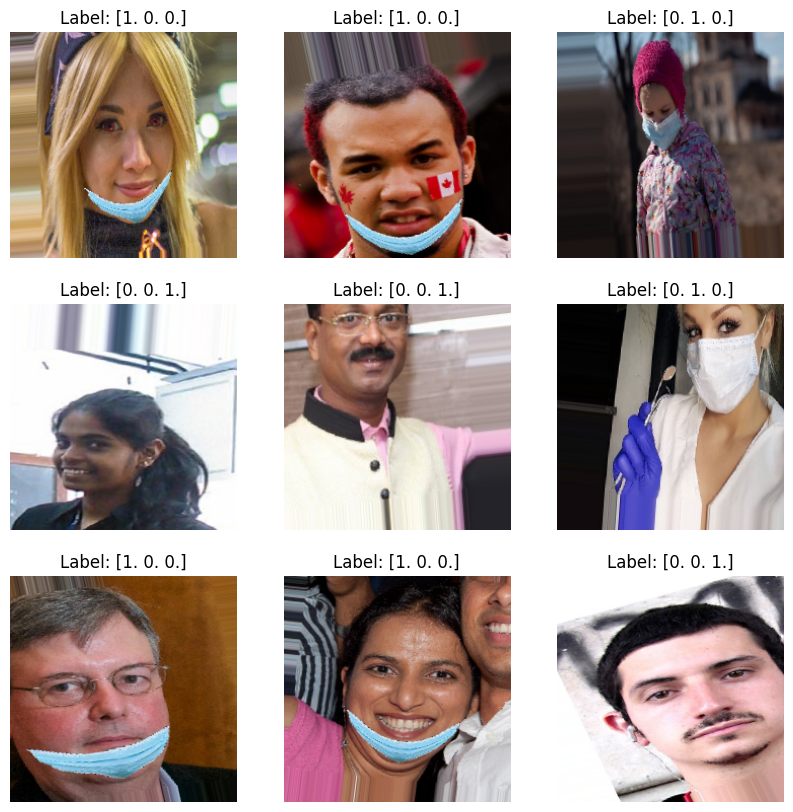

In [ ]:
# Print the overall tensor shapes
print("Train tensor shape:", train_generator[0][0].shape)
print("Validation tensor shape:", val_generator[0][0].shape)
print("Test tensor shape:", test_generator[0][0].shape)

# Plot some sample images
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.ravel()

for i in range(9):
    img = train_generator[0][0][i]
    label = train_generator[0][1][i]
    axs[i].imshow(img)
    axs[i].set_title("Label: " + str(label))
    axs[i].axis('off')

plt.show()

## Check if the dataset is imbalanced

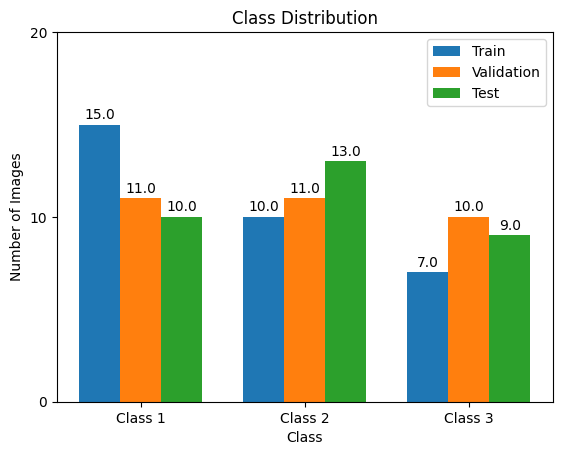

In [ ]:

# Get the number of images in each class
train_class_count = np.sum(train_generator[0][1], axis=0)
val_class_count = np.sum(val_generator[0][1], axis=0)
test_class_count = np.sum(test_generator[0][1], axis=0)

# Create a bar chart to display the class counts
fig, ax = plt.subplots()
x = np.arange(len(train_class_count))
width = 0.25

rects1 = ax.bar(x - width, train_class_count, width, label='Train')
rects2 = ax.bar(x, val_class_count, width, label='Validation')
rects3 = ax.bar(x + width, test_class_count, width, label='Test')

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution')
ax.set_xticks(x)
ax.set_xticklabels(['Class 1', 'Class 2', 'Class 3'])
ax.legend()

# Set the yticks to display the counts
yticks = np.arange(0, max(train_class_count)+10, 10)
ax.set_yticks(yticks)

for rect1, rect2, rect3 in zip(rects1, rects2, rects3):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    height3 = rect3.get_height()
    ax.annotate(f'{height1}', xy=(rect1.get_x() + rect1.get_width() / 2, height1),
                xytext=(0, 2), textcoords="offset points", ha='center', va='bottom')
    ax.annotate(f'{height2}', xy=(rect2.get_x() + rect2.get_width() / 2, height2),
                xytext=(0, 2), textcoords="offset points", ha='center', va='bottom')
    ax.annotate(f'{height3}', xy=(rect3.get_x() + rect3.get_width() / 2, height3),
                xytext=(0, 2), textcoords="offset points", ha='center', va='bottom')

plt.show()

## Model

In [ ]:
# Define the model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 128)      0

Epoch 1/30
29/29 [==============================] - 84s 3s/step - loss: 1.1665 - accuracy: 0.4133 - val_loss: 0.9507 - val_accuracy: 0.7843
Epoch 2/30
29/29 [==============================] - 66s 2s/step - loss: 0.7923 - accuracy: 0.6833 - val_loss: 0.5509 - val_accuracy: 0.8126
Epoch 3/30
29/29 [==============================] - 64s 2s/step - loss: 0.5728 - accuracy: 0.7789 - val_loss: 0.3395 - val_accuracy: 0.8932
Epoch 4/30
29/29 [==============================] - 68s 2s/step - loss: 0.4328 - accuracy: 0.8356 - val_loss: 0.3605 - val_accuracy: 0.8540
Epoch 5/30
29/29 [==============================] - 69s 2s/step - loss: 0.3316 - accuracy: 0.8733 - val_loss: 0.2107 - val_accuracy: 0.9041
Epoch 6/30
29/29 [==============================] - 70s 2s/step - loss: 0.2992 - accuracy: 0.8989 - val_loss: 0.2272 - val_accuracy: 0.9237
Epoch 7/30
29/29 [==============================] - 67s 2s/step - loss: 0.3308 - accuracy: 0.8644 - val_loss: 0.2218 - val_accuracy: 0.9259
Epoch 8/30
29/29 [==

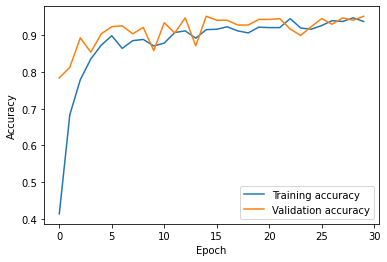

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=30, validation_data=val_generator)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

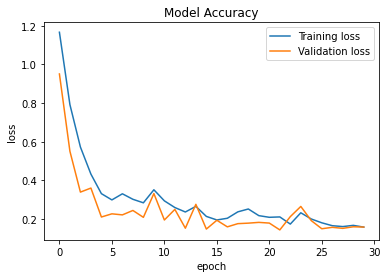

In [ ]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss vs epochs
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
import os

root_path = "D:\Winter23\COMP263_DeepLearning_SEC002\Project\Models"
filename = f"SupervisedClassifier_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
path = os.path.join(root_path, filename)

model.save(path)

In [ ]:
from sklearn.metrics import classification_report

# Load the trained classifier
saved_model = tf.keras.models.load_model(path)

# Generate predictions on the test images
predictions = saved_model.predict(test_generator)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

5/5 [==============================] - 3s 431ms/step
               precision    recall  f1-score   support

IncorrectMask       0.25      0.26      0.26        50
         Mask       0.29      0.30      0.30        50
      NonMask       0.38      0.36      0.37        50

     accuracy                           0.31       150
    macro avg       0.31      0.31      0.31       150
 weighted avg       0.31      0.31      0.31       150



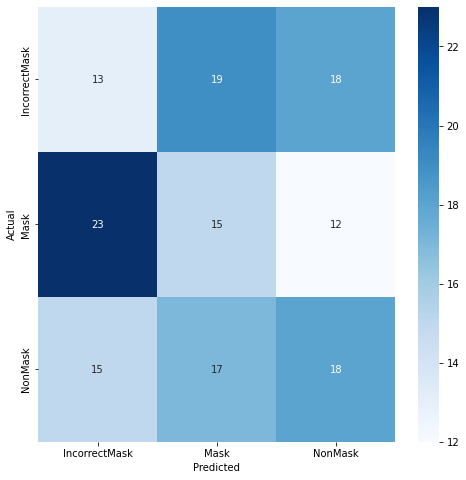

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert class labels to numeric form
label_map = (train_generator.class_indices)
test_labels = test_generator.classes
pred_labels = np.argmax(predictions, axis=-1)

# Plot confusion matrix
cm = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=label_map, yticklabels=label_map)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
cm

array([[13, 19, 18],
       [23, 15, 12],
       [15, 17, 18]], dtype=int64)

## Hyper parameter tuning

In [ ]:
def build_model(hp):
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = inputs
    for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
        filters = hp.Int('filters_' + str(i), 32, 256, step=32)
        for _ in range(2):
            x = tf.keras.layers.Convolution2D(filters, kernel_size=(3, 3), padding='same')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.ReLU()(x)
        if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
            x = tf.keras.layers.MaxPool2D()(x)
        else:
            x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    x = tf.keras.layers.Dense(
        hp.Int('hidden_size', 30, 100, step=10, default=50),
      activation='relu')(x)
    x = tf.keras.layers.Dropout(
        hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

In [ ]:
# Initialize the Hyperband class
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2)

# Run the search method to train the model
%time tuner.search(train_generator,validation_data=val_generator,epochs=30,callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
3                 |3                 |conv_blocks
256               |256               |filters_0
max               |max               |pooling_0
256               |256               |filters_1
avg               |avg               |pooling_1
256               |256               |filters_2
avg               |avg               |pooling_2
50                |50                |hidden_size
0.4               |0.4               |dropout
0.00030615        |0.00030615        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
29/29 [==============================] - 7186s 248s/step - loss: 0.9471 - accuracy: 0.5724 - val_loss: 1.0944 - val_accuracy: 0.3523
Epoch 2/2
27/29 [==========================>...] - ETA: 7:19 - loss: 0.7444 - a

In [ ]:
best_model = tuner.get_best_models(1)[0]

path = "C:\Users\301211308\Downloads\Models\" + f"HTSupervisedClassifier_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
best_model.save(path)

In [ ]:
# Load the trained classifier
saved_model = tf.keras.models.load_model(path)

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [15]:
def create_model():
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = inputs
    x = tf.keras.layers.Convolution2D(256, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Convolution2D(256, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.Convolution2D(256, kernel_size=(3, 3), padding='same')(x)
    x = tf.keras.layers.AvgPool2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(50, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.00030615),
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

In [16]:
# Create the model
model_hp = create_model()

model_hp.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 256)     7168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 256)    0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 256)     590080    
                                                                 
 average_pooling2d_6 (Averag  (None, 56, 56, 256)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 256)       5900

In [17]:
# Train the model
history_hp = model_hp.fit(train_generator, epochs=30, validation_data=val_generator)



Epoch 1/30
47/47 [==============================] - 364s 8s/step - loss: 1.4268 - accuracy: 0.3573 - val_loss: 1.0400 - val_accuracy: 0.3333
Epoch 2/30
47/47 [==============================] - 359s 8s/step - loss: 1.0889 - accuracy: 0.3233 - val_loss: 1.0727 - val_accuracy: 0.4728
Epoch 3/30
47/47 [==============================] - 358s 8s/step - loss: 1.0429 - accuracy: 0.4160 - val_loss: 0.9600 - val_accuracy: 0.5163
Epoch 4/30
47/47 [==============================] - 357s 8s/step - loss: 1.0357 - accuracy: 0.4200 - val_loss: 0.9859 - val_accuracy: 0.5251
Epoch 5/30
47/47 [==============================] - 358s 8s/step - loss: 0.9738 - accuracy: 0.5000 - val_loss: 0.9598 - val_accuracy: 0.5882
Epoch 6/30
47/47 [==============================] - 359s 8s/step - loss: 0.9829 - accuracy: 0.5267 - val_loss: 0.9131 - val_accuracy: 0.5577
Epoch 7/30
47/47 [==============================] - 358s 8s/step - loss: 0.9387 - accuracy: 0.5200 - val_loss: 0.8101 - val_accuracy: 0.7298
Epoch 8/30
47

NameError: name 'model' is not defined

In [18]:
# Evaluate the model on test data
test_loss_hp, test_acc_hp = model_hp.evaluate(test_generator)
print('Test loss:', test_loss_hp)
print('Test accuracy:', test_acc_hp)

5/5 [==============================] - 10s 2s/step - loss: 0.6922 - accuracy: 0.7667
Test loss: 0.6921974420547485
Test accuracy: 0.7666666507720947


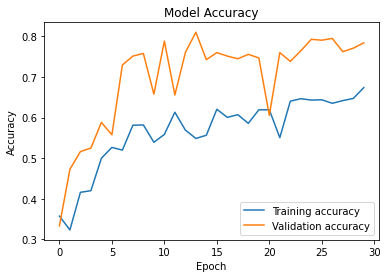

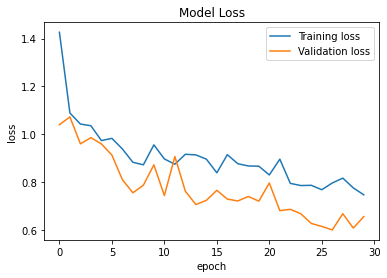

In [19]:
# Plot the training and validation accuracy over epochs
plt.plot(history_hp.history['accuracy'], label='Training accuracy')
plt.plot(history_hp.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss vs epochs
plt.plot(history_hp.history['loss'], label='Training loss')
plt.plot(history_hp.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [22]:
model_hp.save('SupervisedClassifier_19042023.h5')